In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
from imports import *

In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import data_management
from data_management import load_stack
from data_management import load_data

import interactive_plot

import metrics
from metrics import statistics
from metrics import confusion_matrix
from metrics import error_distribution
from metrics import error_borders
from metrics import PR_curve

import generator_extended

import unet
from unet import load_model_unet
from unet import predict_net
from unet import get_unet
from unet import train
from unet import execute_predict

In [6]:
NPYPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/npy/'
MODELPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-12/'
images_file = os.path.join(NPYPATH, 'original.npy')
labels_file = os.path.join(NPYPATH, 'mask.npy')

In [7]:
def get_random_images_and_labels(images, labels, num_imgs = 10):
    random_indices = np.random.choice(len(images), num_imgs)
    
    print(random_indices)
    
    images = np.expand_dims(images, axis=3)
    labels = np.expand_dims(labels, axis=3)

    new_imgs = np.empty([num_imgs, 512, 512, 1])
    new_labels = np.empty([num_imgs, 512, 512, 1])
    z = 0
    for i in random_indices:
        new_imgs[z] = images[i]
        new_labels[z] = labels[i]
        z = z + 1
    return new_imgs, new_labels

In [8]:
images = np.load(images_file)
labels = np.load(labels_file)

In [9]:
random_images, random_labels = get_random_images_and_labels(images, labels, num_imgs=600)

[ 862 1621 1628  265 1438 1136  520 1464  192  485  906  515  362   89
  168   67  990  895 1298 1654  944  486 1808  103 1174 1708  585  941
  799 1491  801  708 1380 1221  827 1613 1004 1064 1016  700  114  215
 1782  927 1140 1434  171  282 1276  664 1386  839  888 1094  621  130
 1810 1732  359 1102  455    4 1473  214  414  444  744  399  298  157
 1078 1031 1067 1745 1758 1443  975  222 1466  900  258 1131 1197  832
  153  842 1515  135  456 1652 1687  868  771 1186  890 1407  375  614
 1101 1039  103  521  422  172 1577  517 1051 1393  727  225  917 1705
 1755   74  190  992 1437  752  234  554  670 1093 1023 1418 1271 1636
  702  838  668  164  961  858  920  314 1677 1700  200 1754  258 1072
 1469 1441  141 1753  818  203 1659  581 1498 1715 1505 1460 1395 1677
 1570  308 1682  355 1609 1578 1685 1581 1289  889  258  999  128 1167
  981  537  132 1402  507  362  167  960  413 1585  941  529   30 1227
  678 1669  413  528 1293 1335  369 1079 1166  203  847  947 1392 1257
 1145 

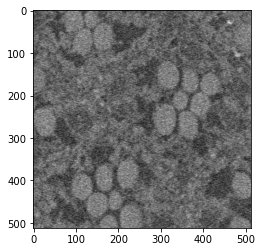

In [10]:
plt.figure(figsize=(7,4))
plt.imshow(random_images[0,:,:,0], cmap='gray')
# bimg = mh.borders(random_images[0,:,:,0]).astype(int)
# res = plt.imshow(bimg, alpha=0.9, cmap='gray')

In [11]:
model_path = os.path.join(MODELPATH, 'weights.84-0.04.hdf5')

In [12]:
model = load_model_unet(model_path, use_dice_loss=False, use_jaccard_loss=False, use_focal_loss=False)

2023-04-12 12:04:33.941813: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-12 12:04:34.079308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-12 12:04:34.082151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-12 12:04:34.082175: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-12 12:04:34.085650: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-12 

In [13]:
model

In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d_10 (SpatialDr (None, 512, 512, 32) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 32) 9248        spatial_dropout2d_10[0][0]       
____________________________________________________________________________________________

In [22]:
len(random_images)

600

In [45]:
input_img, gt = get_random_images_and_labels(images, labels, num_imgs=1)

[1279]


In [46]:
input_img = np.squeeze(input_img, axis=(0,))
gt = np.squeeze(gt, axis=(0,))

In [47]:
PRED_TESTING_PATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-12/predictions/'
        
random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=7))

testing_path = PRED_TESTING_PATH + random_string + '/'

if not os.path.isdir(testing_path):
        os.mkdir(testing_path)

(512, 512, 1)
4.9036745e-15 0.8455959
(512, 512, 1)


True

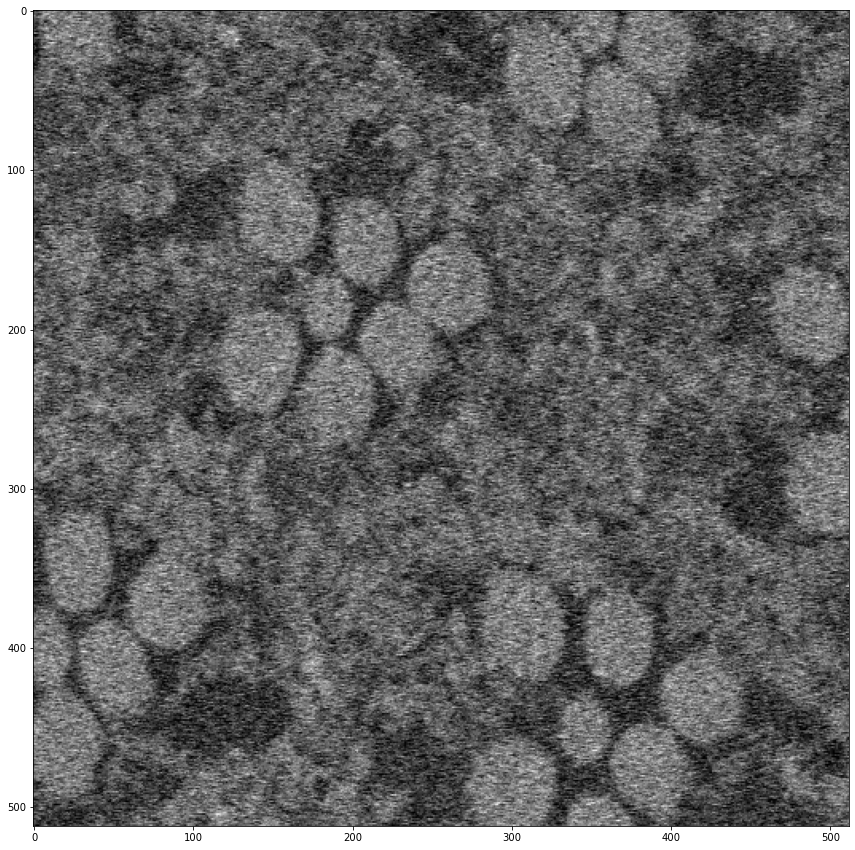

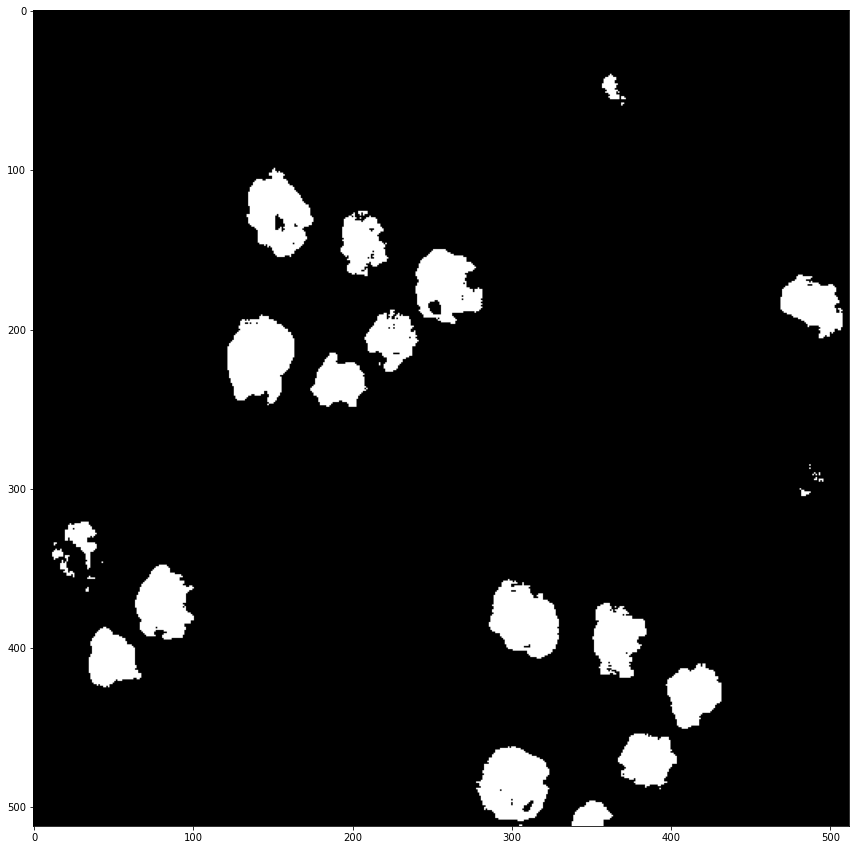

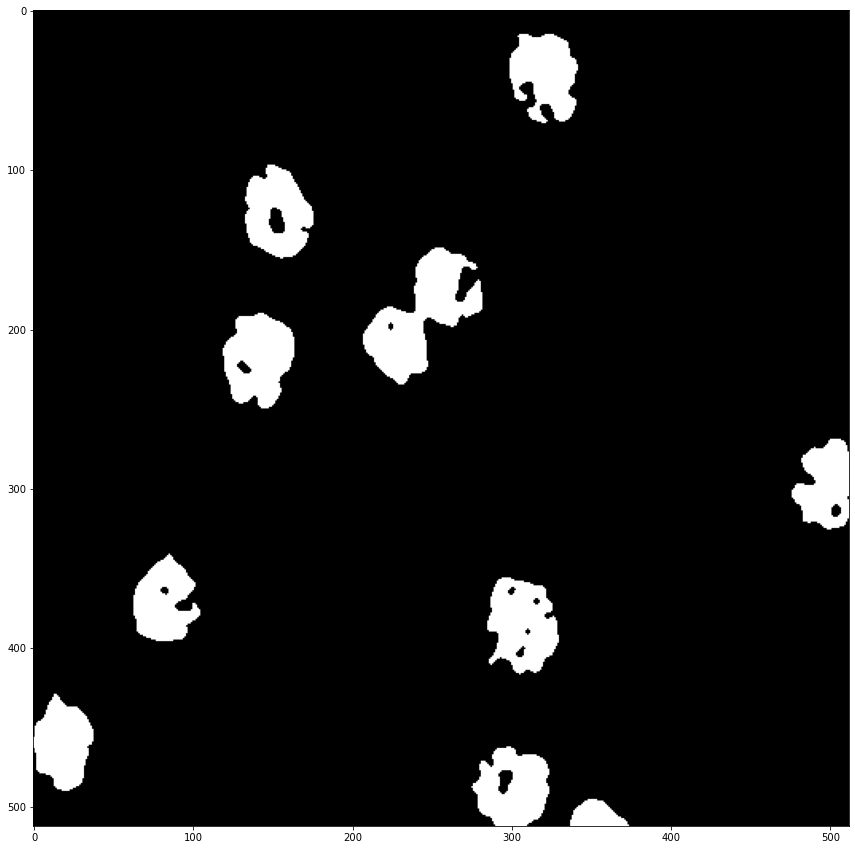

In [49]:
plt.figure(figsize = (15,15))
plt.imshow(input_img, cmap='gray')

print(input_img.shape)
res = execute_predict(model, input_img.reshape(1,512,512,1).astype(float)/255.)
print(res.min(), res.max())

res[res>0.1]=1
res[res<=0.1]=0

plt.figure(figsize = (15,15))
plt.imshow(res[0,:,:,0], cmap='gray')

plt.figure(figsize = (15,15))
plt.imshow(gt[:,:,0], cmap='gray')

print(gt.shape)

cv2.imwrite(os.path.join(testing_path,'example_img_gt.png'), gt)
cv2.imwrite(os.path.join(testing_path, 'example_img_raw.png'), input_img)
cv2.imwrite(os.path.join(testing_path, 'example_img.png'), res[0,:,:,0]*255.)